# Twitter Analysis

Contents:

* [1. Data](#1)
* [2. Class Distribution](#2)
* [3. Number of characters](#3)
* [4. Number of words in a tweet](#4)
* [5. Avg. word length in a tweet](#5)
* [6. Common Stop-words](#6)
* [7. Punctuations](#7)
* [8. Common words](#8)
* [9. Hashtagss](#9)
* [10. Mentions](#10)
* [11. Basic pre-processing](#11)
* [12. Wordclouds](#12)
* [13. N-grams](#13)




In [1]:
!pip install textstat

In [2]:
#Loading libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

#for displaying 500 results in pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


import re
import gensim
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from collections import defaultdict,Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string
nltk.download('stopwords')


stop=set(stopwords.words('english'))
plt.style.use('seaborn')


from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import textstat
from textblob import TextBlob 
from tqdm import tqdm
from statistics import *
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\STARIZ.PK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<a id="1"></a>
    
<font size="+2" color="indigo"><b>1. Data</b></font><br>

In [3]:
train=pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
test=pd.read_csv("Corona_NLP_test.csv",encoding='latin1')



df=pd.concat([train,test])
df['OriginalTweet']=df['OriginalTweet'].astype(str)
df['Sentiment']=df['Sentiment'].astype(str)

train['OriginalTweet']=train['OriginalTweet'].astype(str)
train['Sentiment']=train['Sentiment'].astype(str)

test['OriginalTweet']=test['OriginalTweet'].astype(str)
test['Sentiment']=test['Sentiment'].astype(str)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
print('Training Set Shape = {}'.format(train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test.memory_usage().sum() / 1024**2))
print("\n")
print(train.head())
print("\n")
print(train.info())

Training Set Shape = (41157, 6)
Training Set Memory Usage = 1.88 MB
Test Set Shape = (3798, 6)
Test Set Memory Usage = 0.17 MB


   UserName  ScreenName   Location     TweetAt                                      OriginalTweet           Sentiment
0      3799       48751     London  16-03-2020  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral
1      3800       48752         UK  16-03-2020  advice Talk to your neighbours family to excha...            Positive
2      3801       48753  Vagabonds  16-03-2020  Coronavirus Australia: Woolworths to give elde...            Positive
3      3802       48754        NaN  16-03-2020  My food stock is not the only one which is emp...            Positive
4      3803       48755        NaN  16-03-2020  Me, ready to go at supermarket during the #COV...  Extremely Negative


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  -----

In [6]:
# Drop duplicates
train.drop_duplicates()
print(" Shape of dataframe after dropping duplicates: ", df.shape)

 Shape of dataframe after dropping duplicates:  (44955, 6)


In [7]:
#Null values

null= df.isnull().sum().sort_values(ascending=False)
total =df.shape[0]
percent_missing= (df.isnull().sum()/total).sort_values(ascending=False)

missing_data= pd.concat([null, percent_missing], axis=1, keys=['Total missing', 'Percent missing'])

missing_data.reset_index(inplace=True)
missing_data= missing_data.rename(columns= { "index": " column name"})
 
print ("Null Values in each column:\n", missing_data)


Null Values in each column:
      column name  Total missing  Percent missing
0       Location           9424         0.209632
1       UserName              0         0.000000
2     ScreenName              0         0.000000
3        TweetAt              0         0.000000
4  OriginalTweet              0         0.000000
5      Sentiment              0         0.000000


<AxesSubplot: >

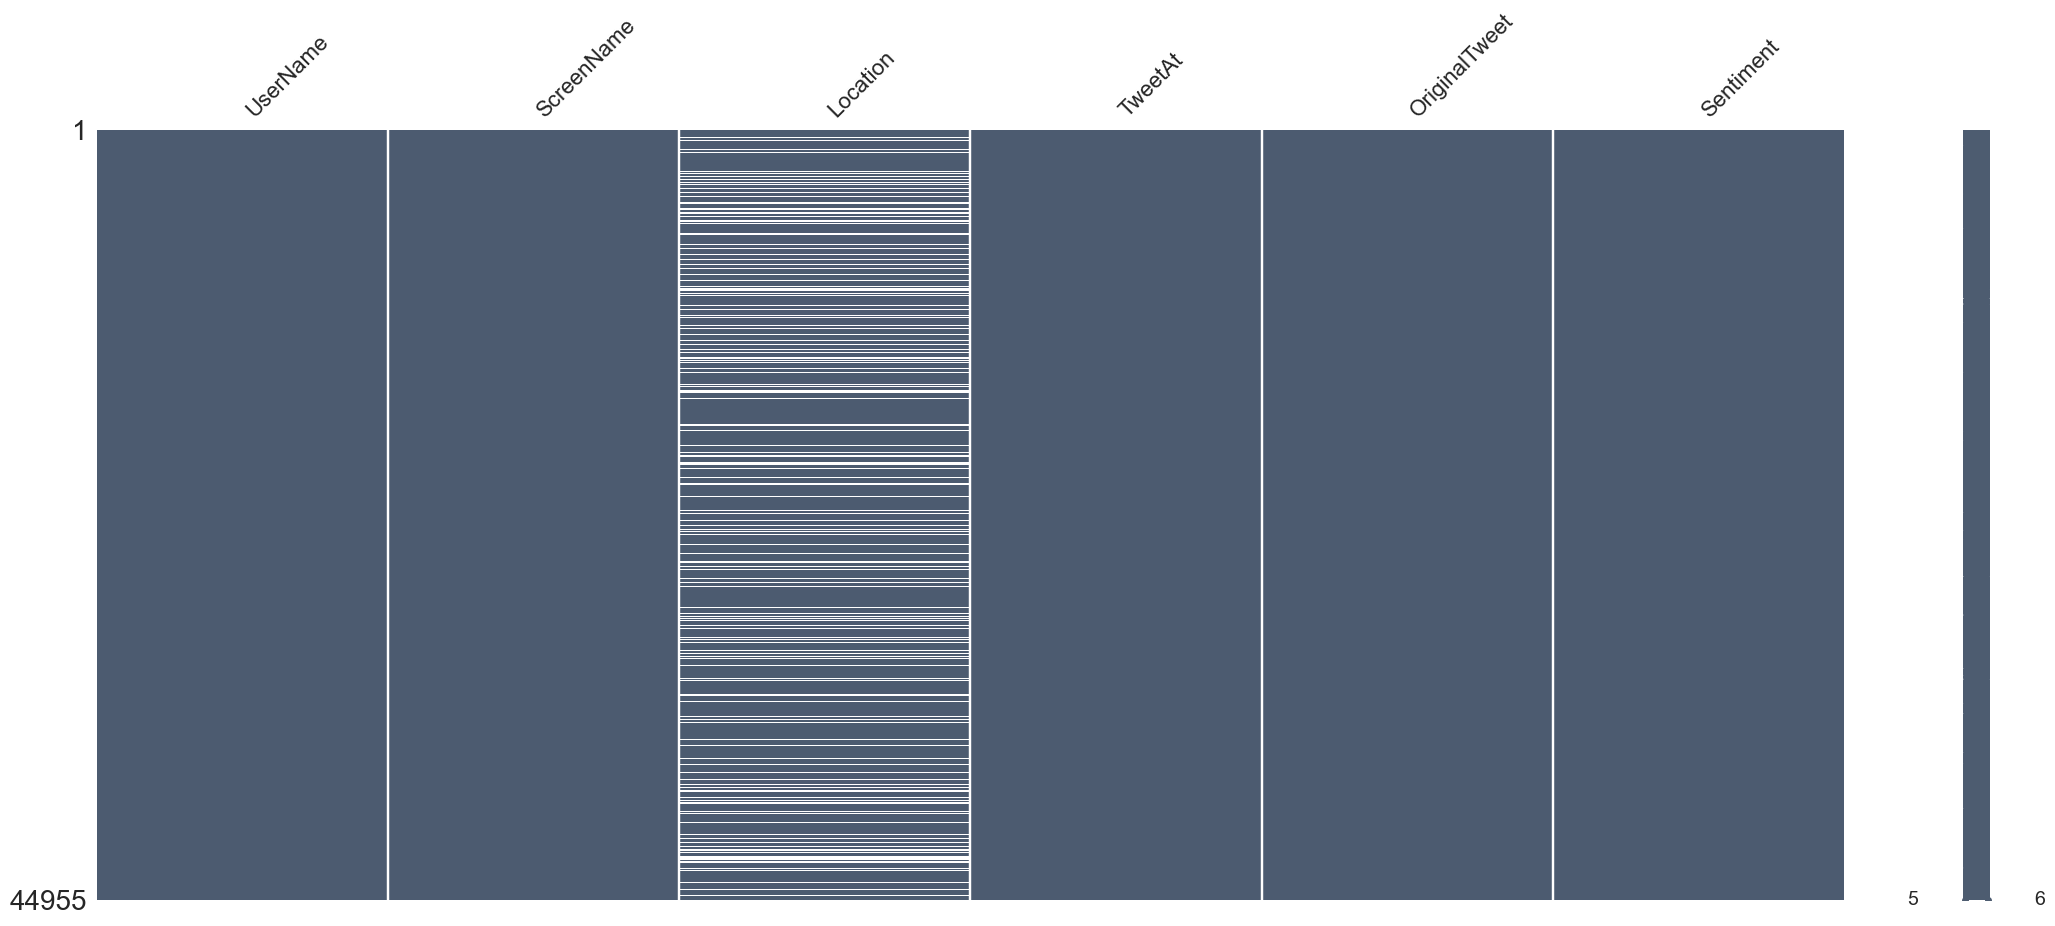

In [8]:
#Missing data as white lines 
import missingno as msno
msno.matrix(df,color=(0.3,0.36,0.44))

#### Null values in location

In [9]:
print('Total tweets in this data: {}'.format(df.shape[0]))
print('Total Unique Users in this data: {}'.format(df['UserName'].nunique()))

Total tweets in this data: 44955
Total Unique Users in this data: 44955


In [10]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Neutral' 'Positive' 'Extremely Negative' 'Negative' 'Extremely Positive']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [11]:
# We will copy the text in another column so that the original text is also there for comparison

df['text'] = df.OriginalTweet
df["text"] = df["text"].astype(str)

train['text'] = train.OriginalTweet
train["text"] = train["text"].astype(str)

test['text'] = test.OriginalTweet
test["text"] = test["text"].astype(str)

# Data has 5 classes, let's convert them to 3

def classes_def(x):
    if x ==  "Extremely Positive":
        return "positive"
    elif x == "Extremely Negative":
        return "negative"
    elif x == "Negative":
        return "negative"
    elif x ==  "Positive":
        return "positive"
    else:
        return "neutral"
    
df['sentiment']=df['Sentiment'].apply(lambda x:classes_def(x))
train['sentiment']=train['Sentiment'].apply(lambda x:classes_def(x))
test['sentiment']=test['Sentiment'].apply(lambda x:classes_def(x))
target=df['sentiment']

df.sentiment.value_counts(normalize= True)
    

positive    0.435814
negative    0.378846
neutral     0.185341
Name: sentiment, dtype: float64

# EDA, Metafeatures & Viz

<a id="2"></a>
    
<font size="+2" color="indigo"><b>2. Class Distribution</b></font><br>


In [12]:
class_df = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
class_df.style.background_gradient(cmap='winter')

,sentiment,text
2,positive,19592
0,negative,17031
1,neutral,8332


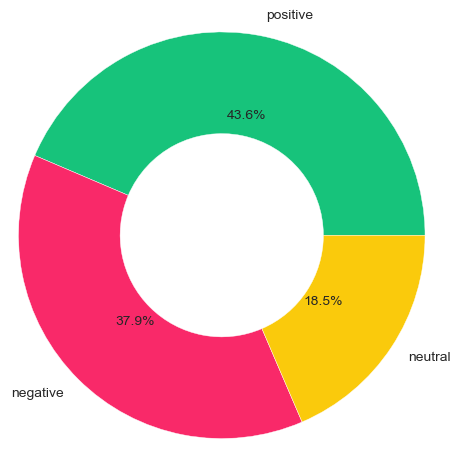

In [13]:
percent_class=class_df.text
labels= class_df.sentiment

colors = ['#17C37B','#F92969','#FACA0C']

my_pie,_,_ = plt.pie(percent_class,radius = 1.2,labels=labels,colors=colors,autopct="%.1f%%")

plt.setp(my_pie, width=0.6, edgecolor='white') 

plt.show()



### There is uneven distribution of classes with positive taking the largest of pie followed by negative.
## The colors used above will represent the classes ahead.

In [14]:
fig=make_subplots(1,2,subplot_titles=('Train set','Test set'))
x=train.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='train'),row=1,col=1)
x=test.sentiment.value_counts()
fig.add_trace(go.Bar(x=x.index,y=x.values,marker_color=['#17C37B','#F92969','#FACA0C'],name='test'),row=1,col=2)

#### Same pattern of uneven distribution in both train and test data



<a id="3"></a>
    
<font size="+2" color="indigo"><b>3. Number of characters</b></font><br>


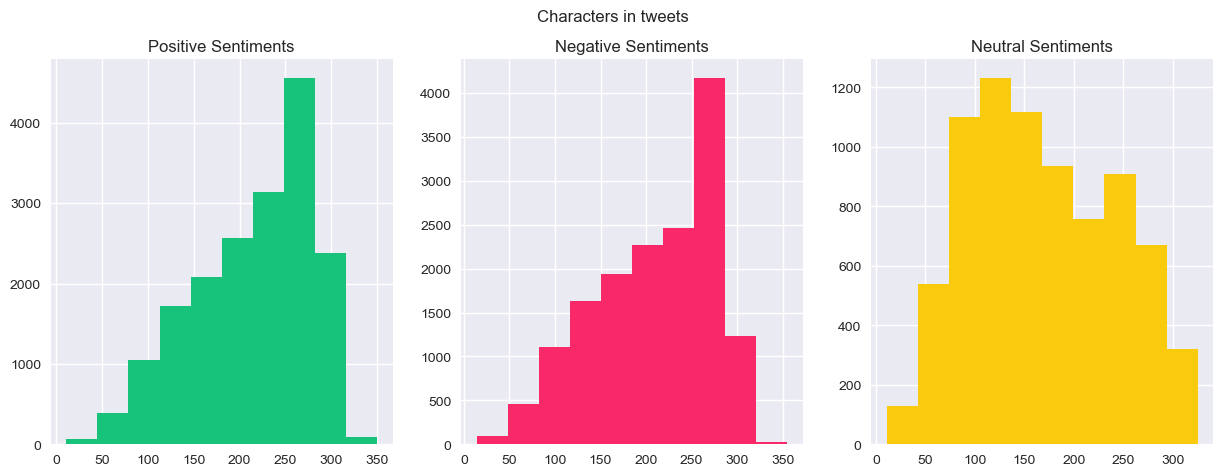

In [15]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')

tweet_len=train[train['sentiment']=="negative"]['text'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

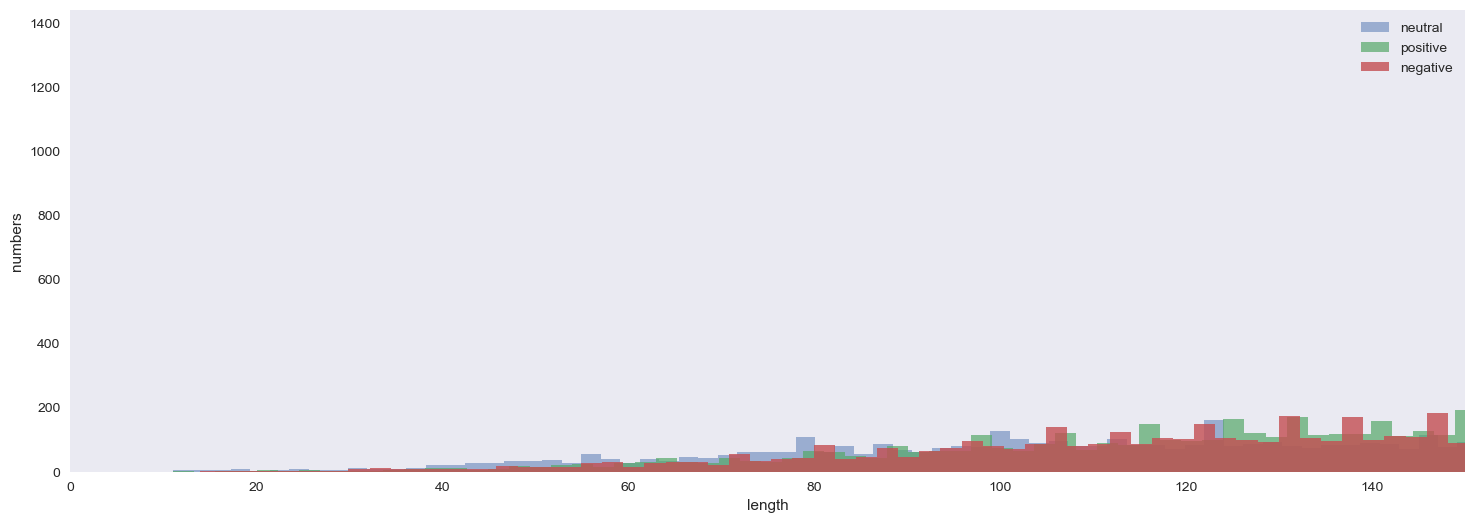

In [16]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)
df['length'] = df['text'].apply(length)

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df[df['sentiment'] == "neutral"]['length'], alpha = 0.5, bins=bins, label='neutral')
plt.hist(df[df['sentiment'] == "positive"]['length'], alpha = 0.7, bins=bins, label='positive')
plt.hist(df[df['sentiment'] == "negative"]['length'], alpha = 0.8, bins=bins, label='negative')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()



<a id="4"></a>
    
<font size="+2" color="indigo"><b>4. Number of words in a tweet</b></font><br>





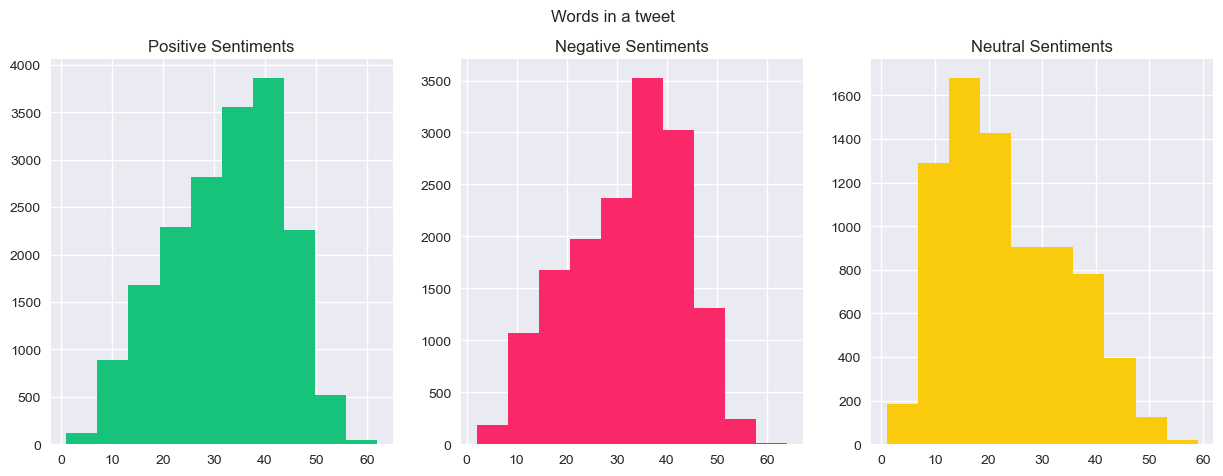

In [17]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train[train['sentiment']=="positive"]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentiments')


tweet_len=train[train['sentiment']=="negative"]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentiments')

tweet_len=train[train['sentiment']=="neutral"]['text'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()



<a id="5"></a>
    
<font size="+2" color="indigo"><b>5. Average word length in a tweet</b></font><br>






Text(0.5, 0.98, 'Average word length in each tweet')

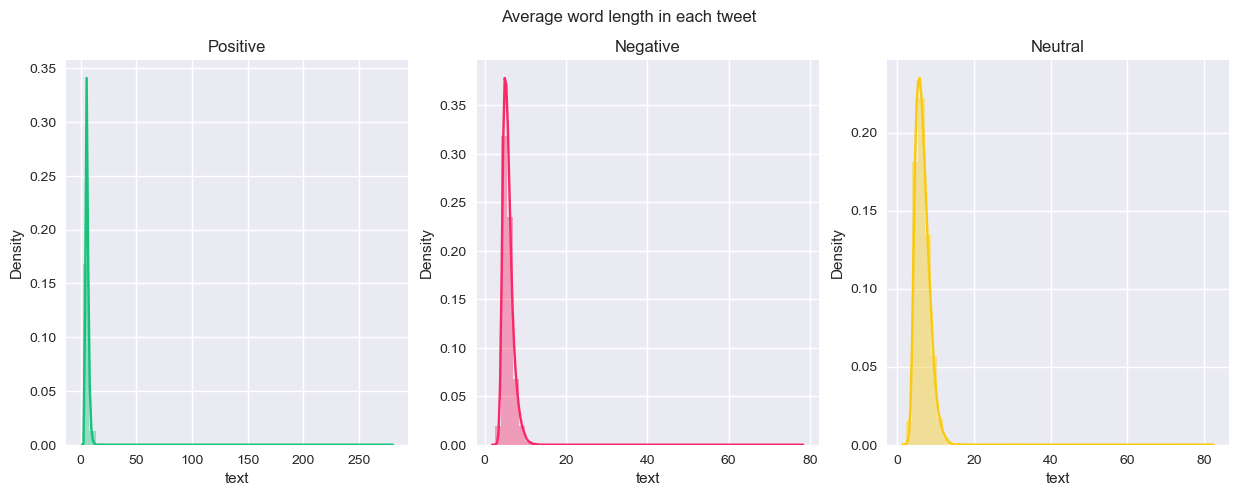

In [18]:
fig,(ax1,ax2, ax3)=plt.subplots(1,3,figsize=(15,5))

word=train[train['sentiment']=="positive"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='#17C37B')
ax1.set_title('Positive')


word=train[train['sentiment']=="negative"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='#F92969')
ax2.set_title('Negative')

word=train[train['sentiment']=="neutral"]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='#FACA0C')
ax3.set_title('Neutral')


fig.suptitle('Average word length in each tweet')



<a id="6"></a>
    
<font size="+2" color="indigo"><b>6. Common Stopwords in the tweets</b></font><br>



In [19]:
def create_corpus(target):
    corpus=[]
    
    for x in train[train['sentiment']==target ]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [20]:
np.array(stop)

array({'ll', 'once', 'other', "she's", 'shouldn', 'd', 'wouldn', 'themselves', "couldn't", 'didn', 'ain', 'has', "you'd", 'too', 'will', 'such', 'very', 'an', "that'll", 'after', 'so', 'not', "needn't", 'if', 'some', 'ourselves', 'does', 'these', "hasn't", 'above', "it's", 'weren', 'won', "wouldn't", 'on', 'do', "shan't", 't', 'm', 'than', 'from', 'were', 'needn', "won't", 'this', 'which', 'are', "weren't", 'mightn', 'of', "you've", "should've", "don't", 'to', 'yourself', 'did', 's', 'how', 've', 'mustn', 'all', 'was', "hadn't", 'further', 'our', 'and', 'same', 'now', 'herself', 'your', 'hers', 'with', 'why', 'their', 'aren', 'y', 'ma', 'she', 'who', "didn't", 'them', 'no', 'doesn', 'couldn', 'about', 'into', "you'll", 'nor', 'up', 'haven', 'shan', 'doing', 'o', 'under', 'it', 'in', 'we', 'her', 'against', 'only', 'below', 'ours', 'most', 'yours', 'while', 'those', 'i', 'during', 'you', 'him', 'but', 'here', "mustn't", 'what', "wasn't", 'there', 'having', 'before', 'hasn', 'isn', 'bein

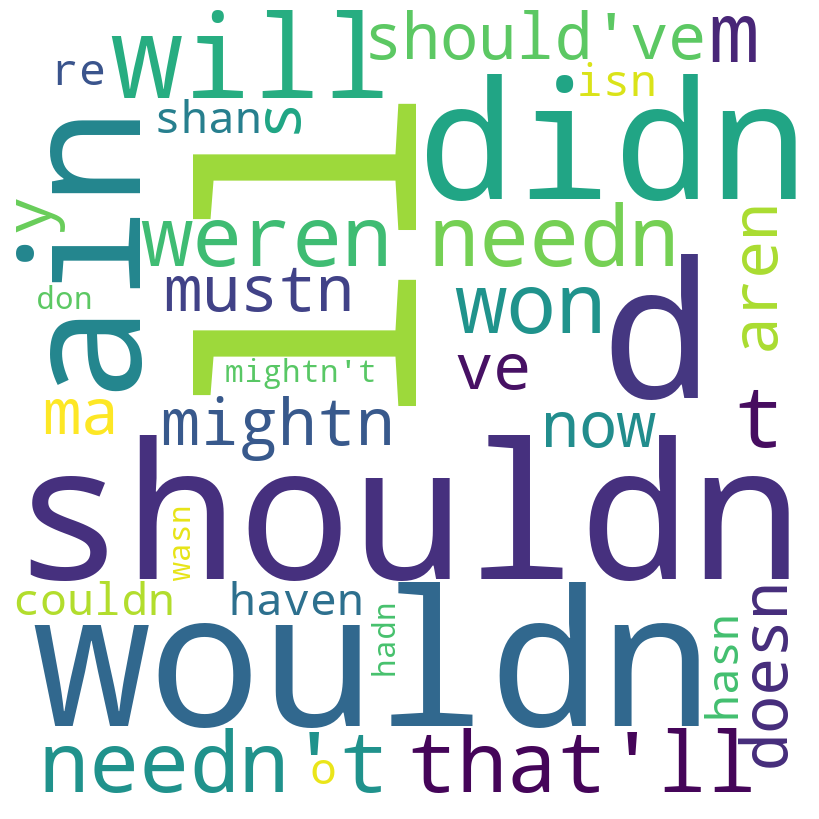

In [21]:
comment_words = '' 
stopwords = set(STOPWORDS) 
  

for val in stop: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

<BarContainer object of 10 artists>

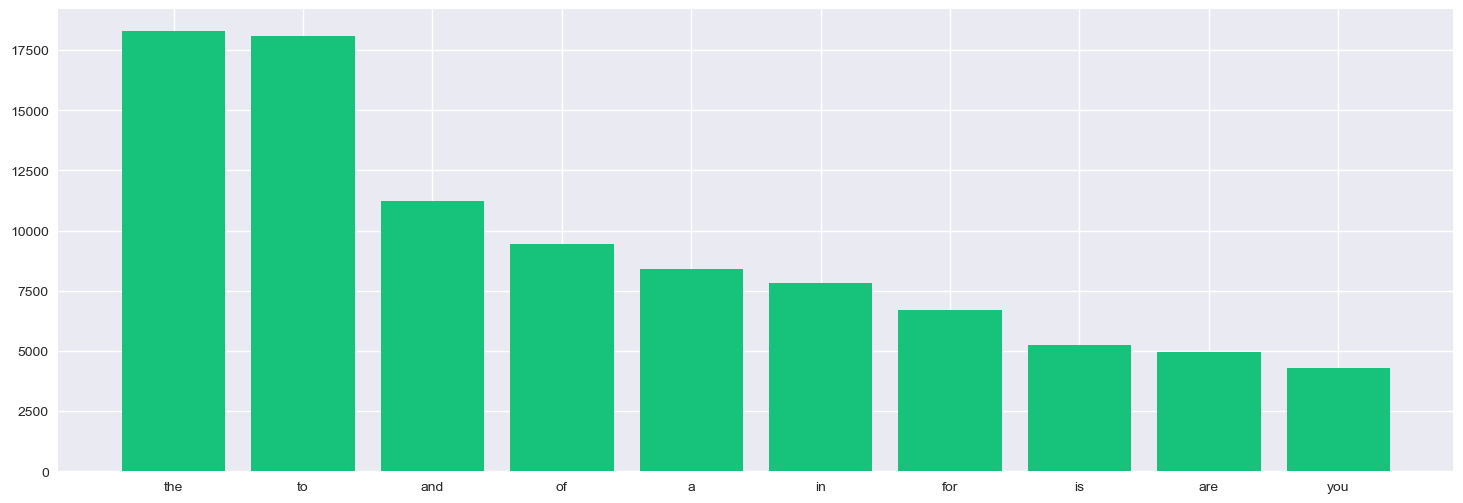

In [22]:
corpus=create_corpus("positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

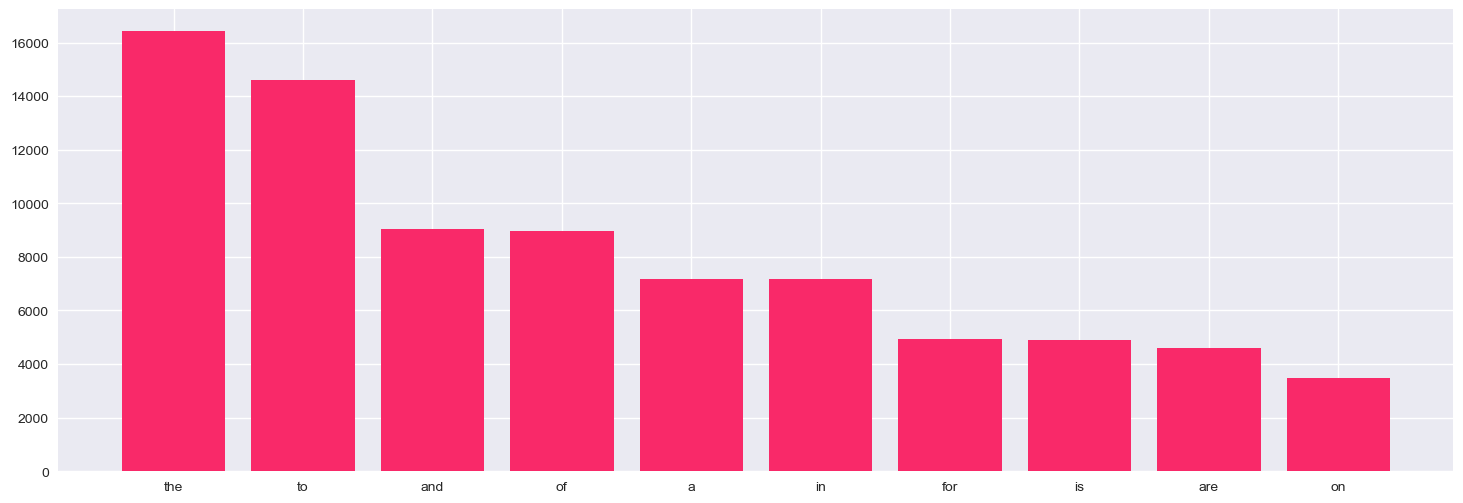

In [23]:
corpus=create_corpus("negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')

<BarContainer object of 10 artists>

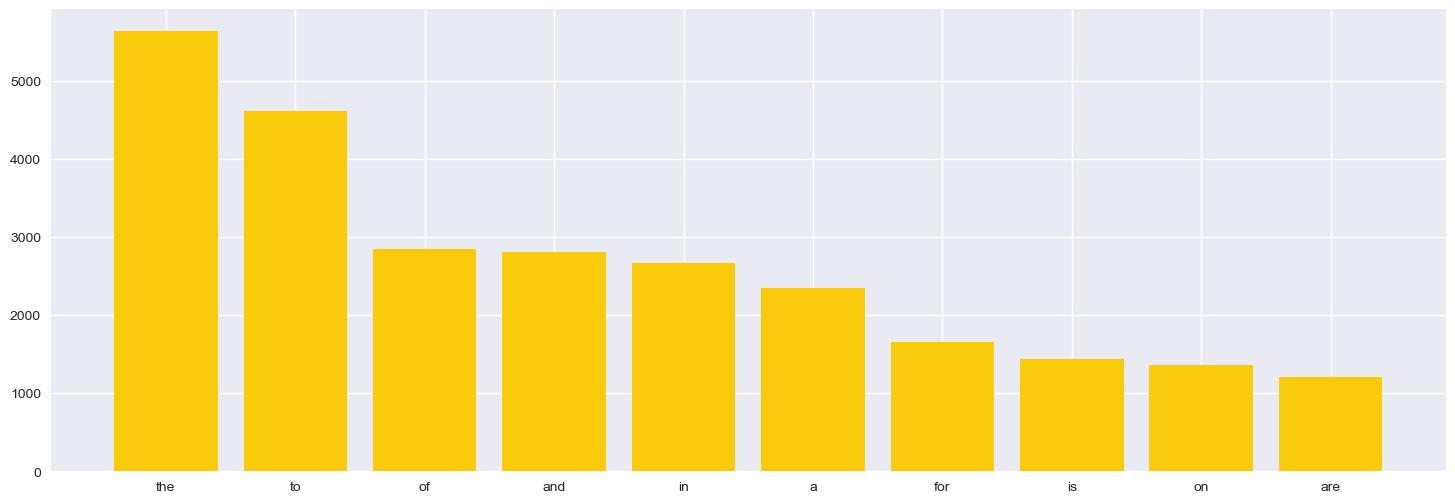

In [24]:
corpus=create_corpus("neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

#### A lot stopwords are present. Require preprocessing



<a id="7"></a>
    
<font size="+2" color="indigo"><b>7. Punctuations</b></font><br>

 




<BarContainer object of 27 artists>

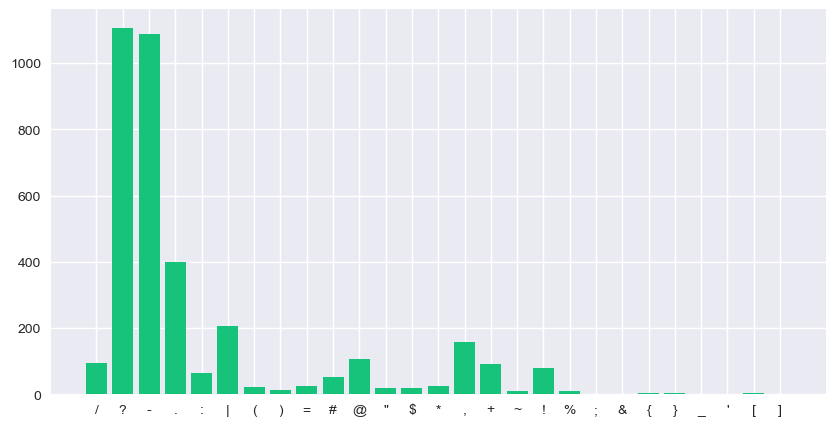

In [25]:
plt.figure(figsize=(10,5))
corpus=create_corpus("positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 25 artists>

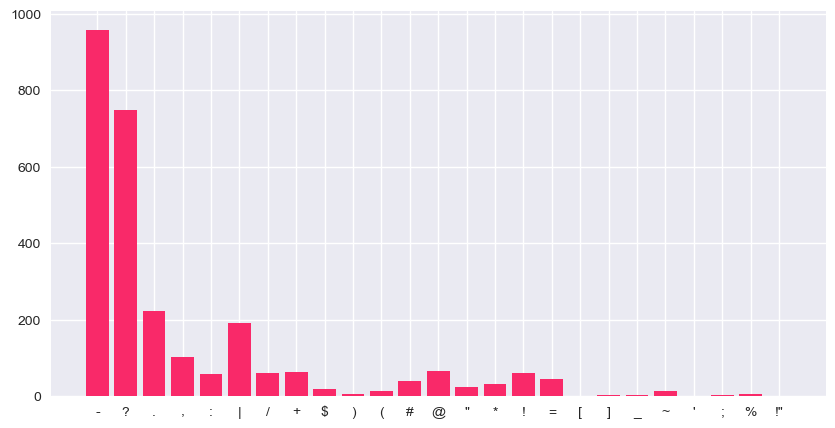

In [26]:
plt.figure(figsize=(10,5))
corpus=create_corpus("negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

<BarContainer object of 23 artists>

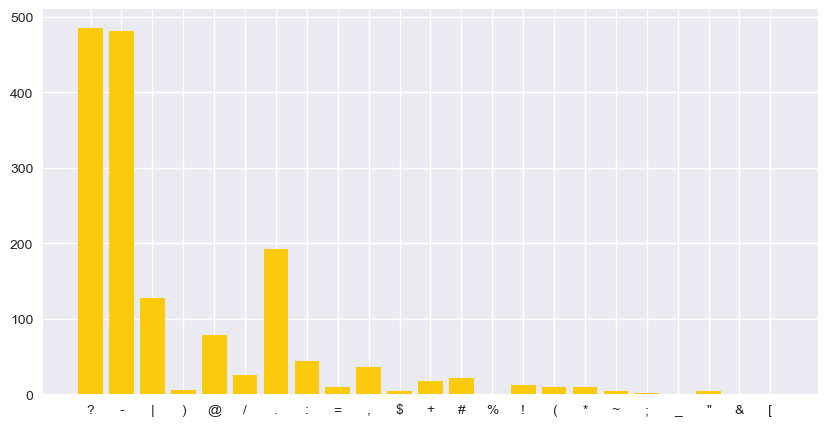

In [27]:
plt.figure(figsize=(10,5))
corpus=create_corpus("neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')

#### More cleaning to be done



<a id="8"></a>
    
<font size="+2" color="indigo"><b>8. Common Words</b></font><br>



In [28]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

<AxesSubplot: >

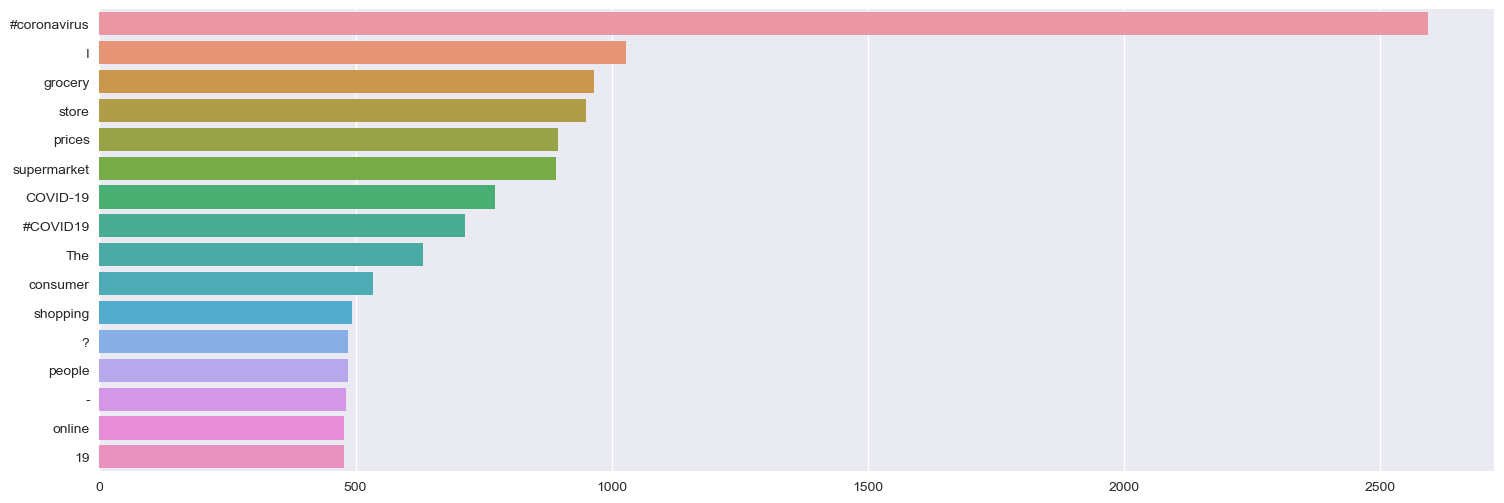

In [29]:
sns.barplot(x=y,y=x)

#### Common words feature punctuations, we need extensive data cleaning



<a id="9"></a>
    
<font size="+2" color="indigo"><b>9. Hashtags</b></font><br>


<AxesSubplot: xlabel='Hashtag', ylabel='count'>

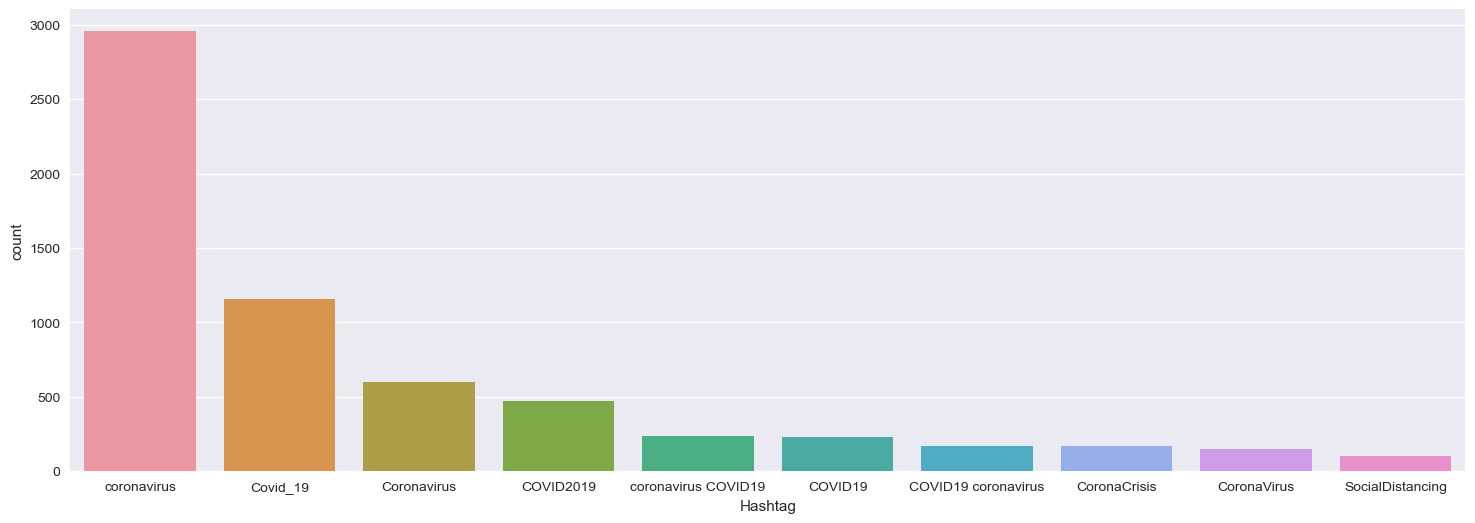

In [30]:
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)
df['hash']=df['text'].apply(lambda x:find_hash(x))
temp=df['hash'].value_counts()[:][1:11]
temp= temp.to_frame().reset_index().rename(columns={'index':'Hashtag','hash':'count'})
sns.barplot(x="Hashtag",y="count", data = temp)

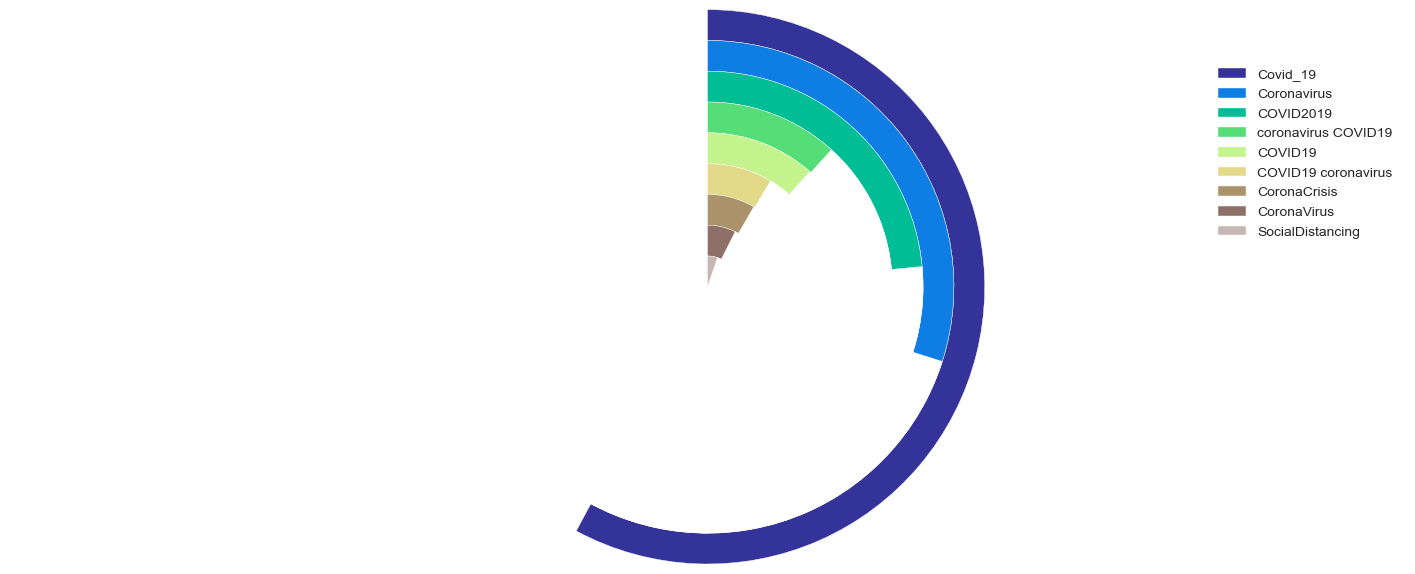

In [31]:
from matplotlib import cm
from math import log10

labels = df['hash'].value_counts()[:][2:11].index.tolist()
data = df['hash'].value_counts()[:][2:11]

df['hash'].value_counts()[:][1:11].index.tolist()
#number of data points
n = len(data)
#find max value for full ring
k = 10 ** int(log10(max(data)))
m = k * (1 + max(data) // k)

#radius of donut chart
r = 1.5
#calculate width of each ring
w = r / n 

#create colors along a chosen colormap
colors = [cm.terrain(i / n) for i in range(n)]

#create figure, axis
fig, ax = plt.subplots()
ax.axis("equal")

#create rings of donut chart
for i in range(n):
    #hide labels in segments with textprops: alpha = 0 - transparent, alpha = 1 - visible
    innerring, _ = ax.pie([m - data[i], data[i]], radius = r - i * w, startangle = 90, labels = ["", labels[i]], labeldistance = 1 - 1 / (1.5 * (n - i)), textprops = {"alpha": 0}, colors = ["white", colors[i]])
    plt.setp(innerring, width = w, edgecolor = "white")

plt.legend()
plt.show()

#### While lower casing is required, we can see that hashtags contain keywords related to coronavirus 



<a id="10"></a>
    
<font size="+2" color="indigo"><b>10. Mentions</b></font><br>



<AxesSubplot: xlabel='Mentions', ylabel='count'>

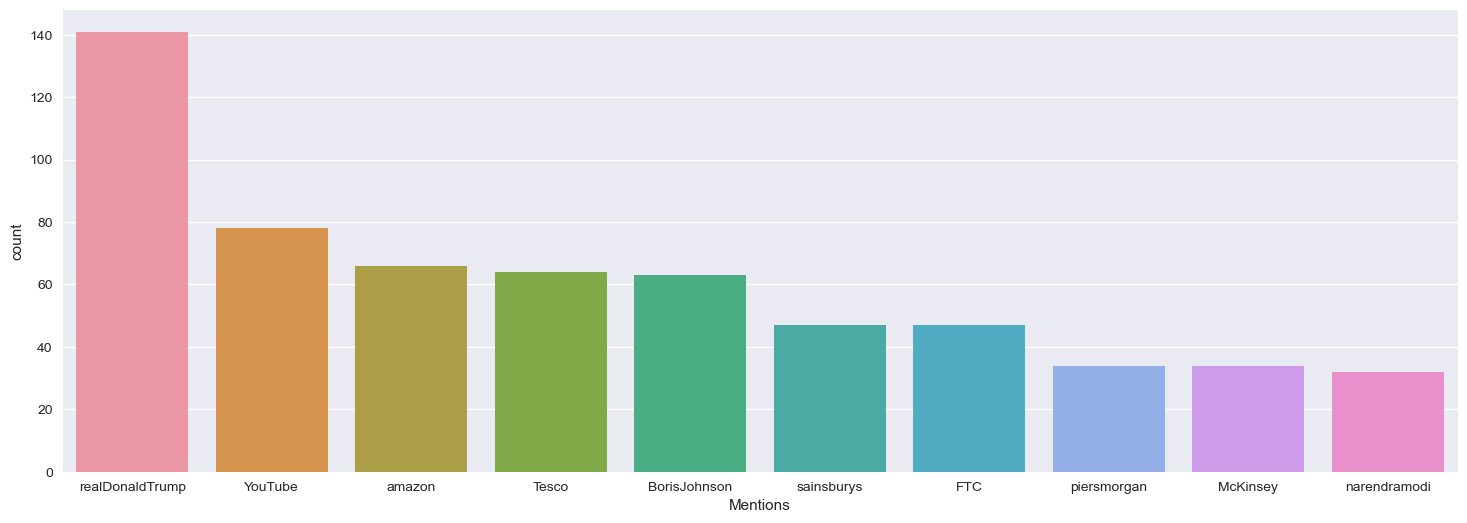

In [32]:

def mentions(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)
df['mentions']=df['text'].apply(lambda x:mentions(x))

temp=df['mentions'].value_counts()[:][1:11]
temp =temp.to_frame().reset_index().rename(columns={'index':'Mentions','mentions':'count'})

sns.barplot(x="Mentions",y="count", data = temp)

In [33]:
b = df['mentions'].value_counts()[:][1:11].index.tolist()
a = df['mentions'].value_counts()[:][1:11].tolist()
row = pd.DataFrame({'scenario' : []})
row["scenario"] = b
row["Percentage"] = a
fig = px.treemap(row, path= ["scenario"], values="Percentage",title='Tree of Mentions')
fig.show()



<a id="11"></a>
    
<font size="+2" color="indigo"><b>11. Pre-processing</b></font><br>



In [34]:
#Remove Urls and HTML links
def remove_urls(text):
    url_remove = re.compile(r'https?://\S+|www\.\S+')
    return url_remove.sub(r'', text)
df['text_new']=df['text'].apply(lambda x:remove_urls(x))

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)
df['text']=df['text_new'].apply(lambda x:remove_html(x))



In [35]:

# Lower casing
def lower(text):
    low_text= text.lower()
    return low_text
df['text_new']=df['text'].apply(lambda x:lower(x))


# Number removal
def remove_num(text):
    remove= re.sub(r'\d+', '', text)
    return remove
df['text']=df['text_new'].apply(lambda x:remove_num(x))



In [36]:

#Remove stopwords & Punctuations
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

def punct_remove(text):
    punct = re.sub(r"[^\w\s\d]","", text)
    return punct
df['text_new']=df['text'].apply(lambda x:punct_remove(x))



def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
df['text']=df['text_new'].apply(lambda x:remove_stopwords(x))



In [37]:
#Remove mentions and hashtags
def remove_mention(x):
    text=re.sub(r'@\w+','',x)
    return text
df['text_new']=df['text'].apply(lambda x:remove_mention(x))
def remove_hash(x):
    text=re.sub(r'#\w+','',x)
    return text
df['text']=df['text_new'].apply(lambda x:remove_hash(x))


In [38]:

#Remove extra white space left while removing stuff
def remove_space(text):
    space_remove = re.sub(r"\s+"," ",text).strip()
    return space_remove
df['text_new']=df['text'].apply(lambda x:remove_space(x))

df = df.drop(columns=['text_new'])



<a id="12"></a>
    
<font size="+2" color="indigo"><b>12. Wordclouds</b></font><br>


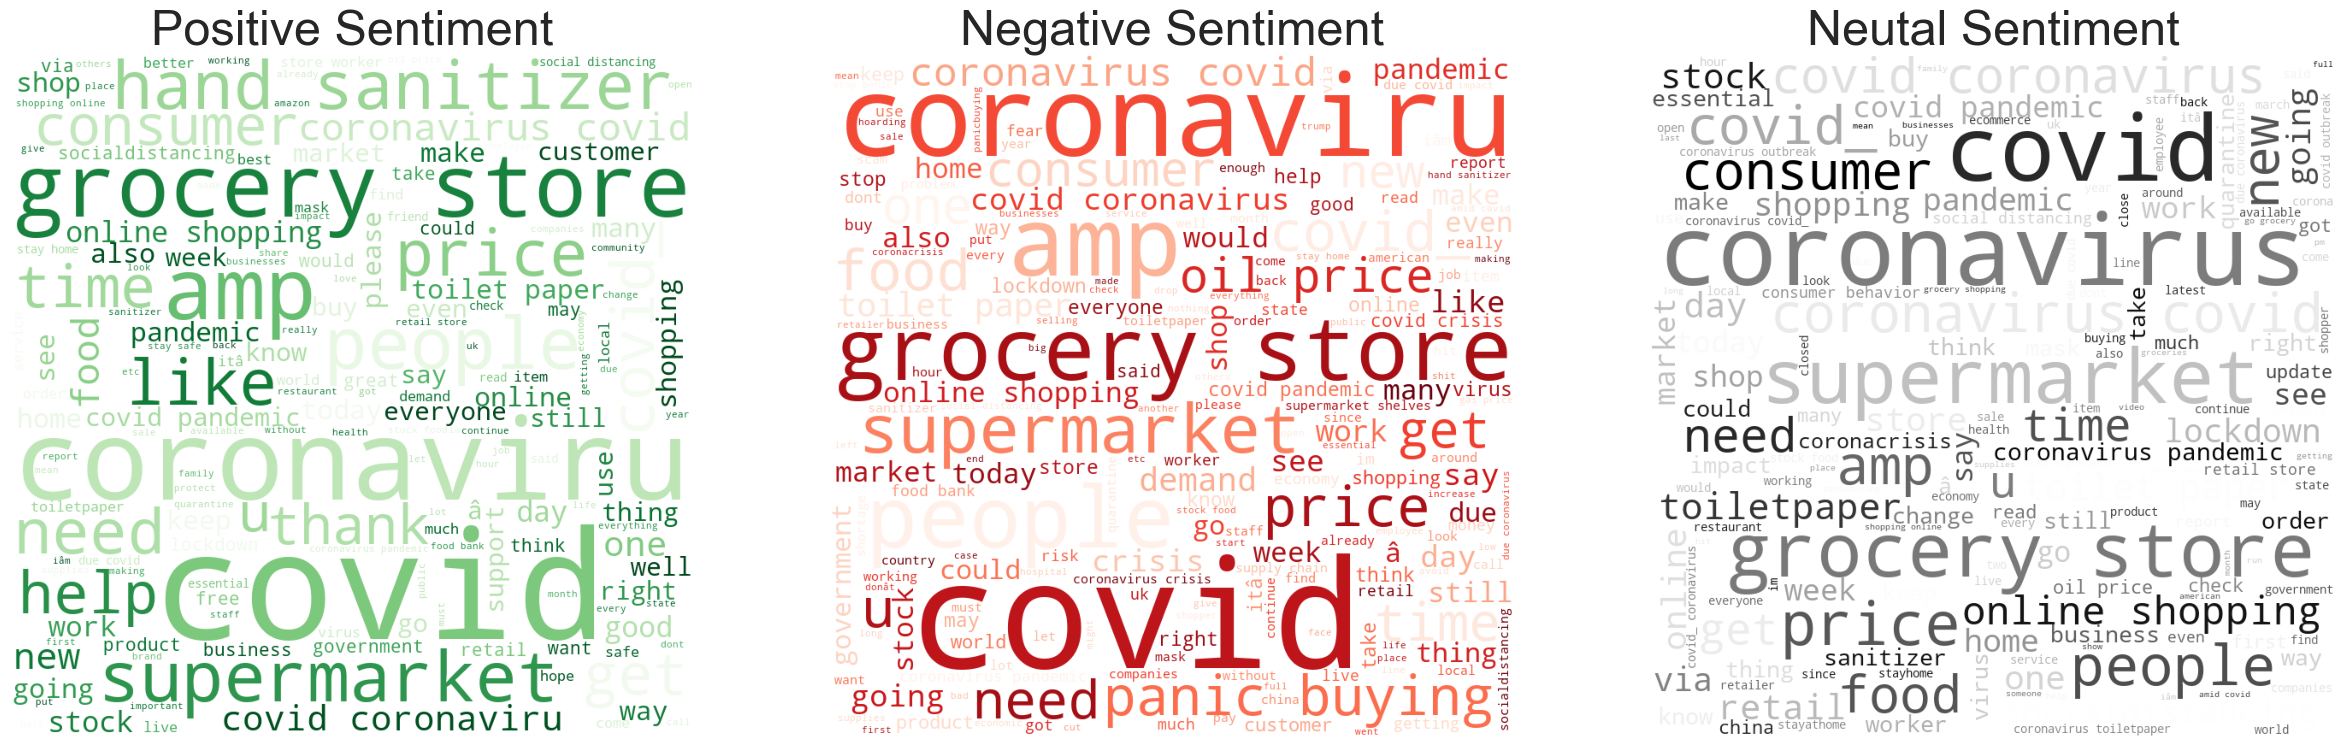

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[30, 15])

df_pos = df[df["sentiment"]=="positive"]
df_neg = df[df["sentiment"]=="negative"]
df_neu = df[df["sentiment"]=="neutral"]

comment_words = '' 
stopwords = set(STOPWORDS) 

for val in df_pos.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
   

wordcloud1 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greens",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Positive Sentiment',fontsize=35);

comment_words = ''

for val in df_neg.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "




wordcloud2 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Reds",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)  
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Negative Sentiment',fontsize=35);



comment_words = ''
for val in df_neu.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "

wordcloud3 = WordCloud(width = 800, height = 800, 
                background_color ='white',
                colormap="Greys",
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
ax3.imshow(wordcloud3)
ax3.axis('off')
ax3.set_title('Neutal Sentiment',fontsize=35);

In [40]:
del df_pos
del df_neg
del df_neu



<a id="13"></a>
    
<font size="+2" color="indigo"><b>13. N-grams</b></font><br>


## Unigrams

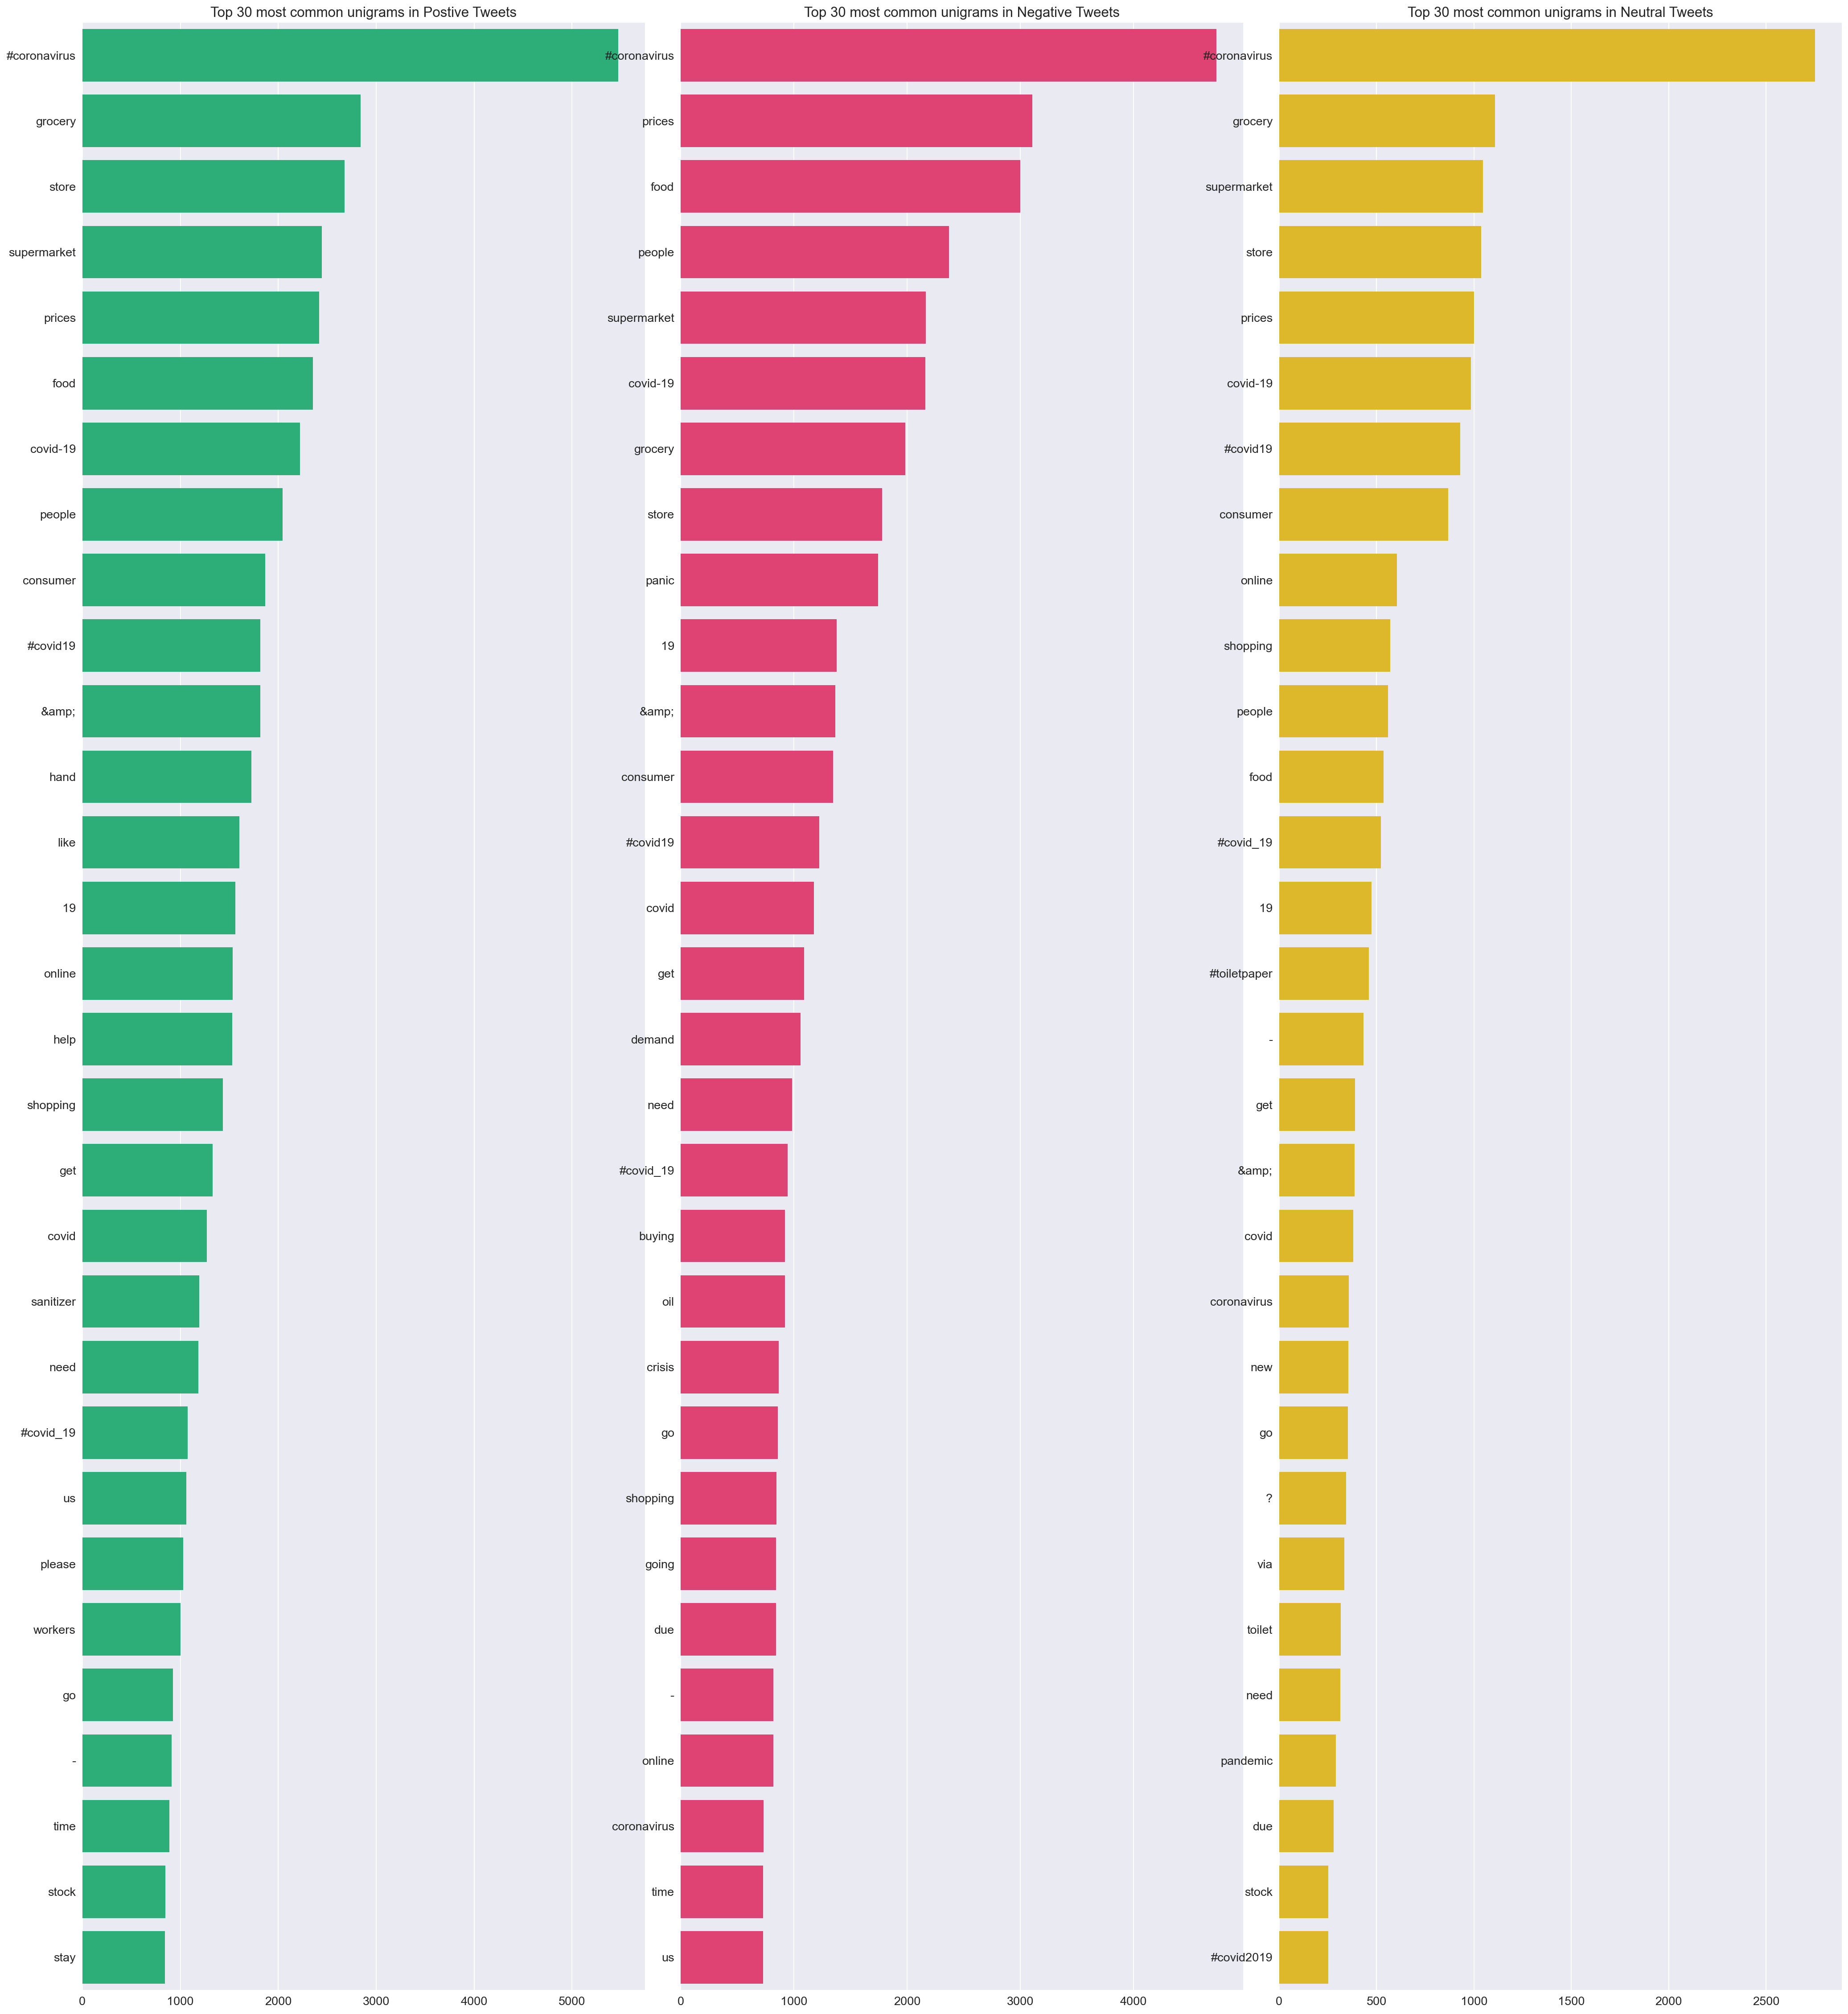

In [41]:
# Define functions
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 30



positive= train["sentiment"]== "positive"
negative= train["sentiment"]== "negative"
neutral= train["sentiment"]== "neutral"

positive_unigrams = defaultdict(int)
neutral_unigrams = defaultdict(int)
negative_unigrams = defaultdict(int)

# Unigrams
for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet):
        positive_unigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet):
        negative_unigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet):
        neutral_unigrams[word] += 1        
        
df_positive_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
df_negative_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_unigrams = pd.DataFrame(sorted(neutral_unigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=150)
plt.tight_layout()

sns.barplot(y=df_positive_unigrams[0].values[:N], x=df_positive_unigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_unigrams[0].values[:N], x=df_negative_unigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_unigrams[0].values[:N], x=df_neutral_unigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=15)

plt.show()

## Bi grams

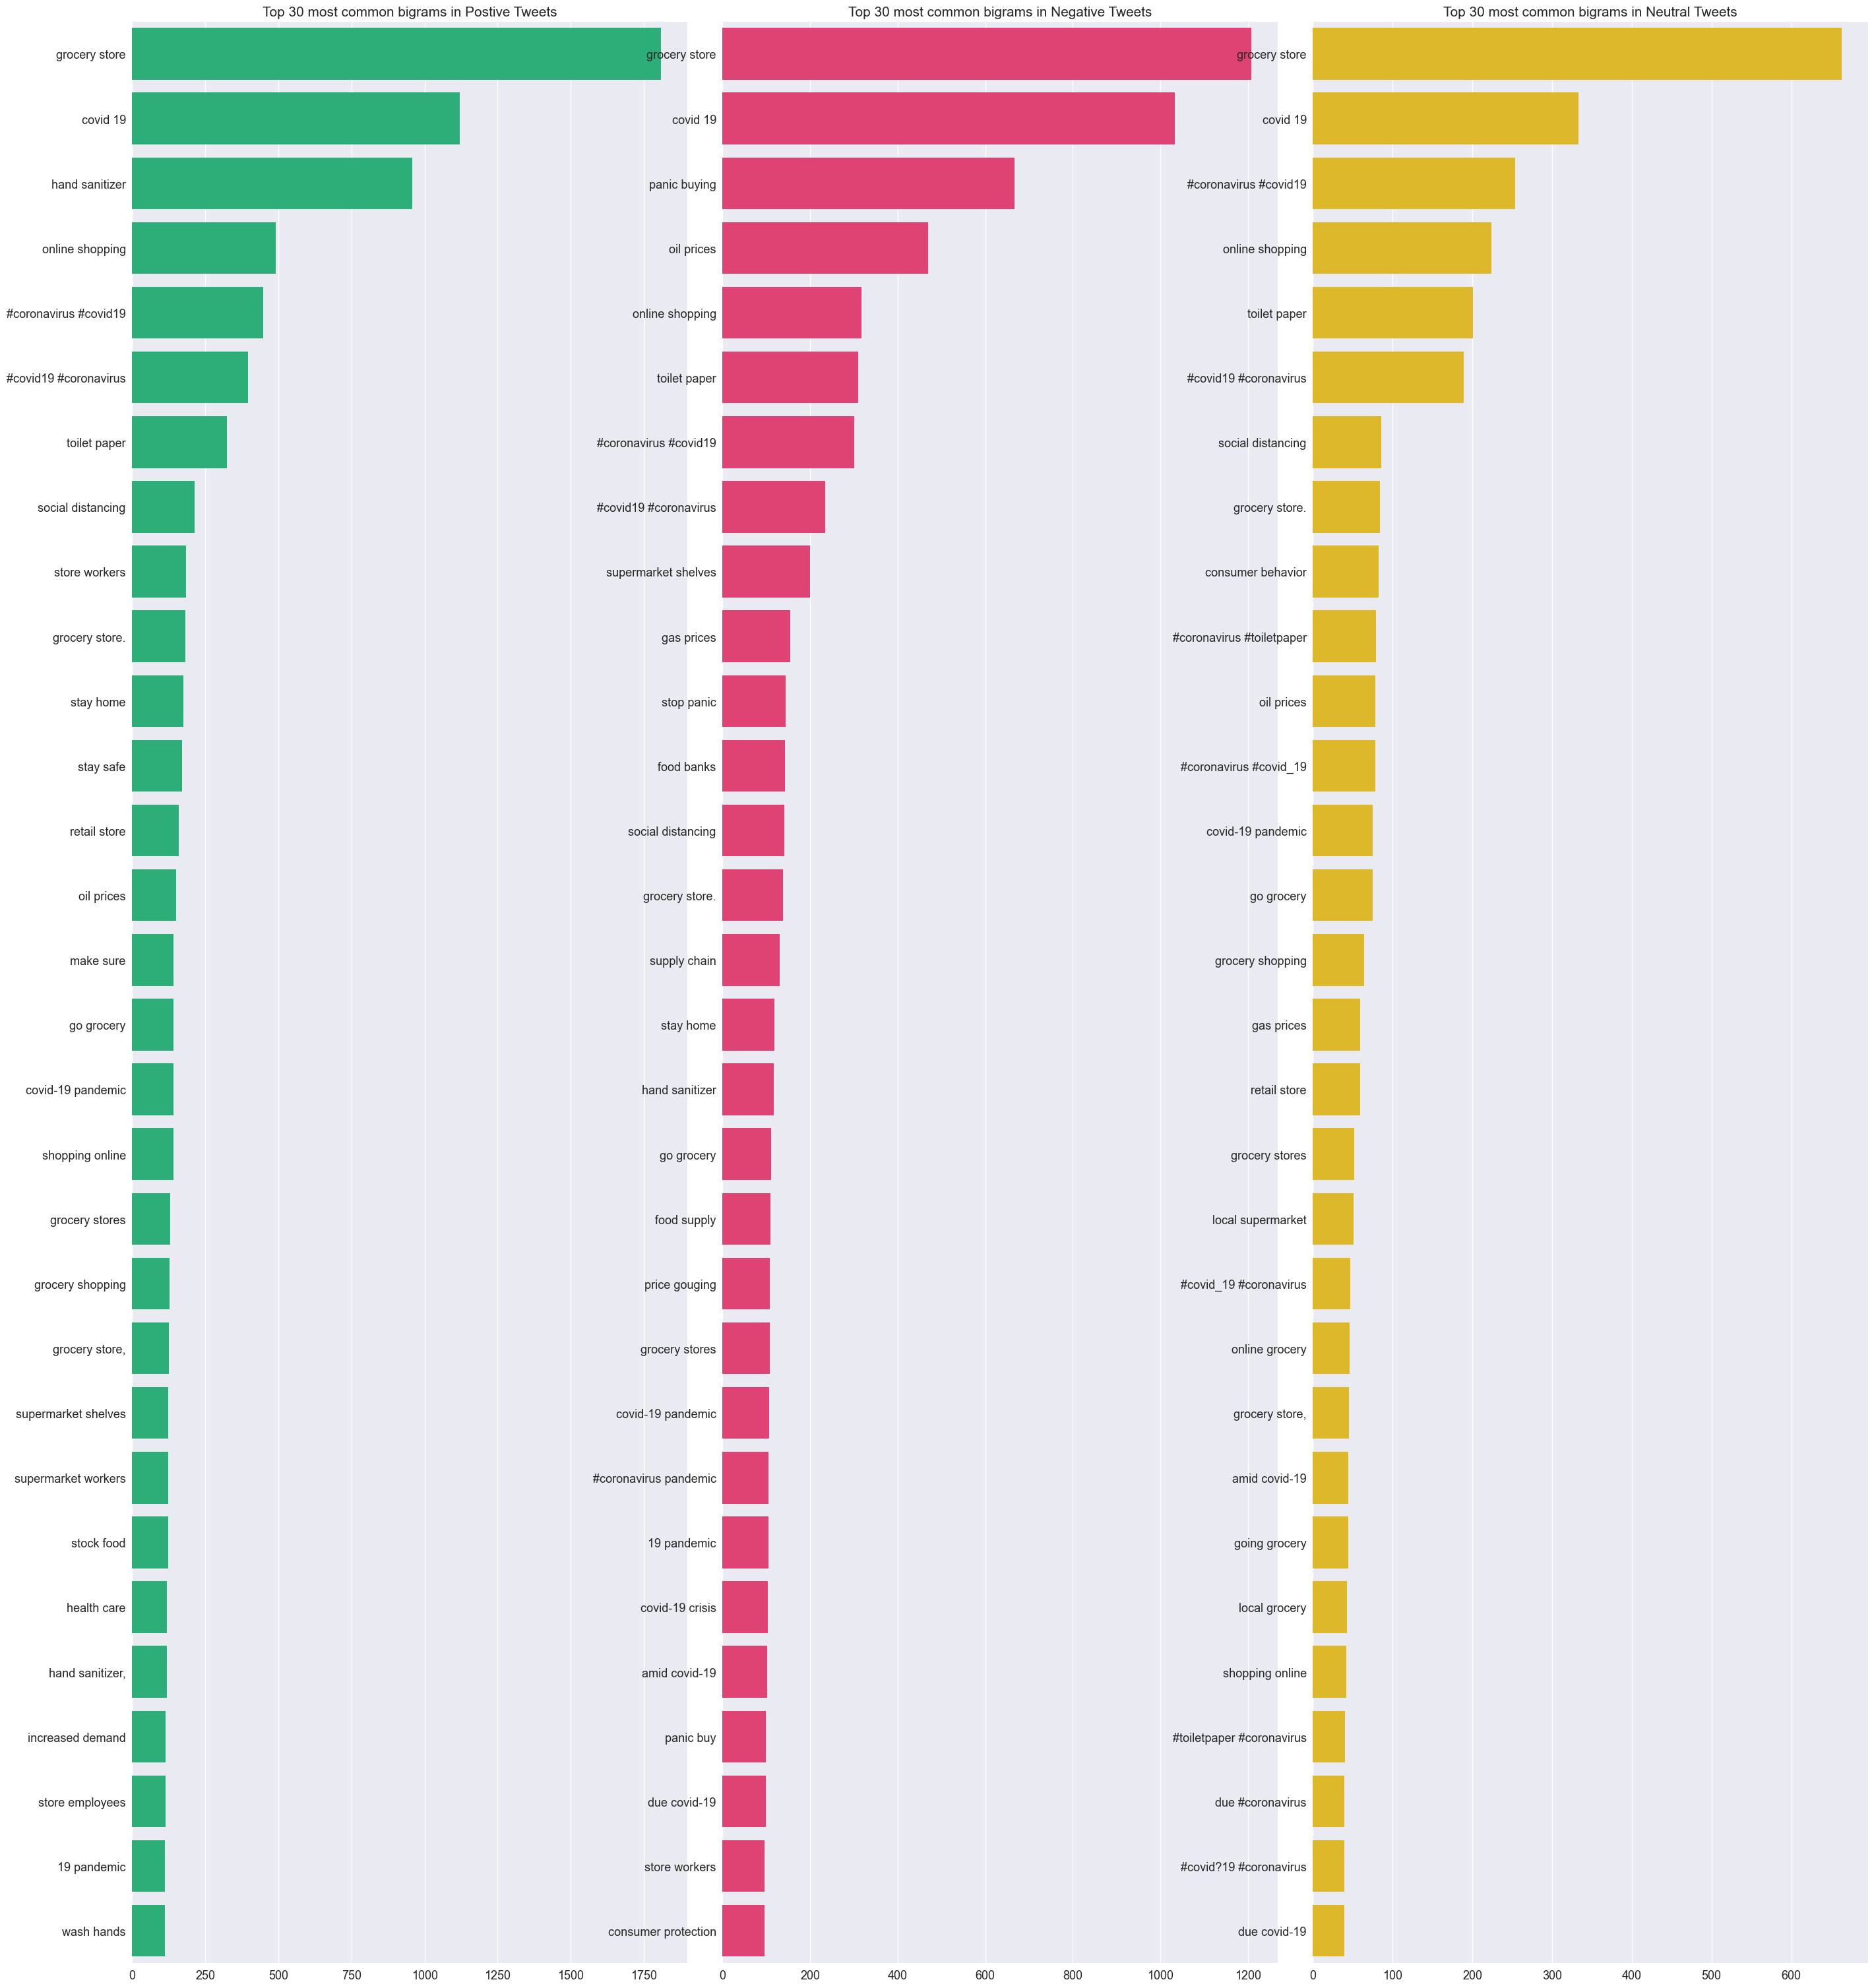

In [42]:
# Bigrams
positive_bigrams = defaultdict(int)
neutral_bigrams = defaultdict(int)
negative_bigrams = defaultdict(int)

for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        positive_bigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        negative_bigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        neutral_bigrams[word] += 1        
        
df_positive_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
df_negative_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_bigrams = pd.DataFrame(sorted(neutral_bigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_bigrams[0].values[:N], x=df_positive_bigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_bigrams[0].values[:N], x=df_negative_bigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_bigrams[0].values[:N], x=df_neutral_bigrams[1].values[:N], ax=axes[2], color='#FACA0C')


for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common bigrams in Neutral Tweets', fontsize=15)

plt.show()

# Tri-grams

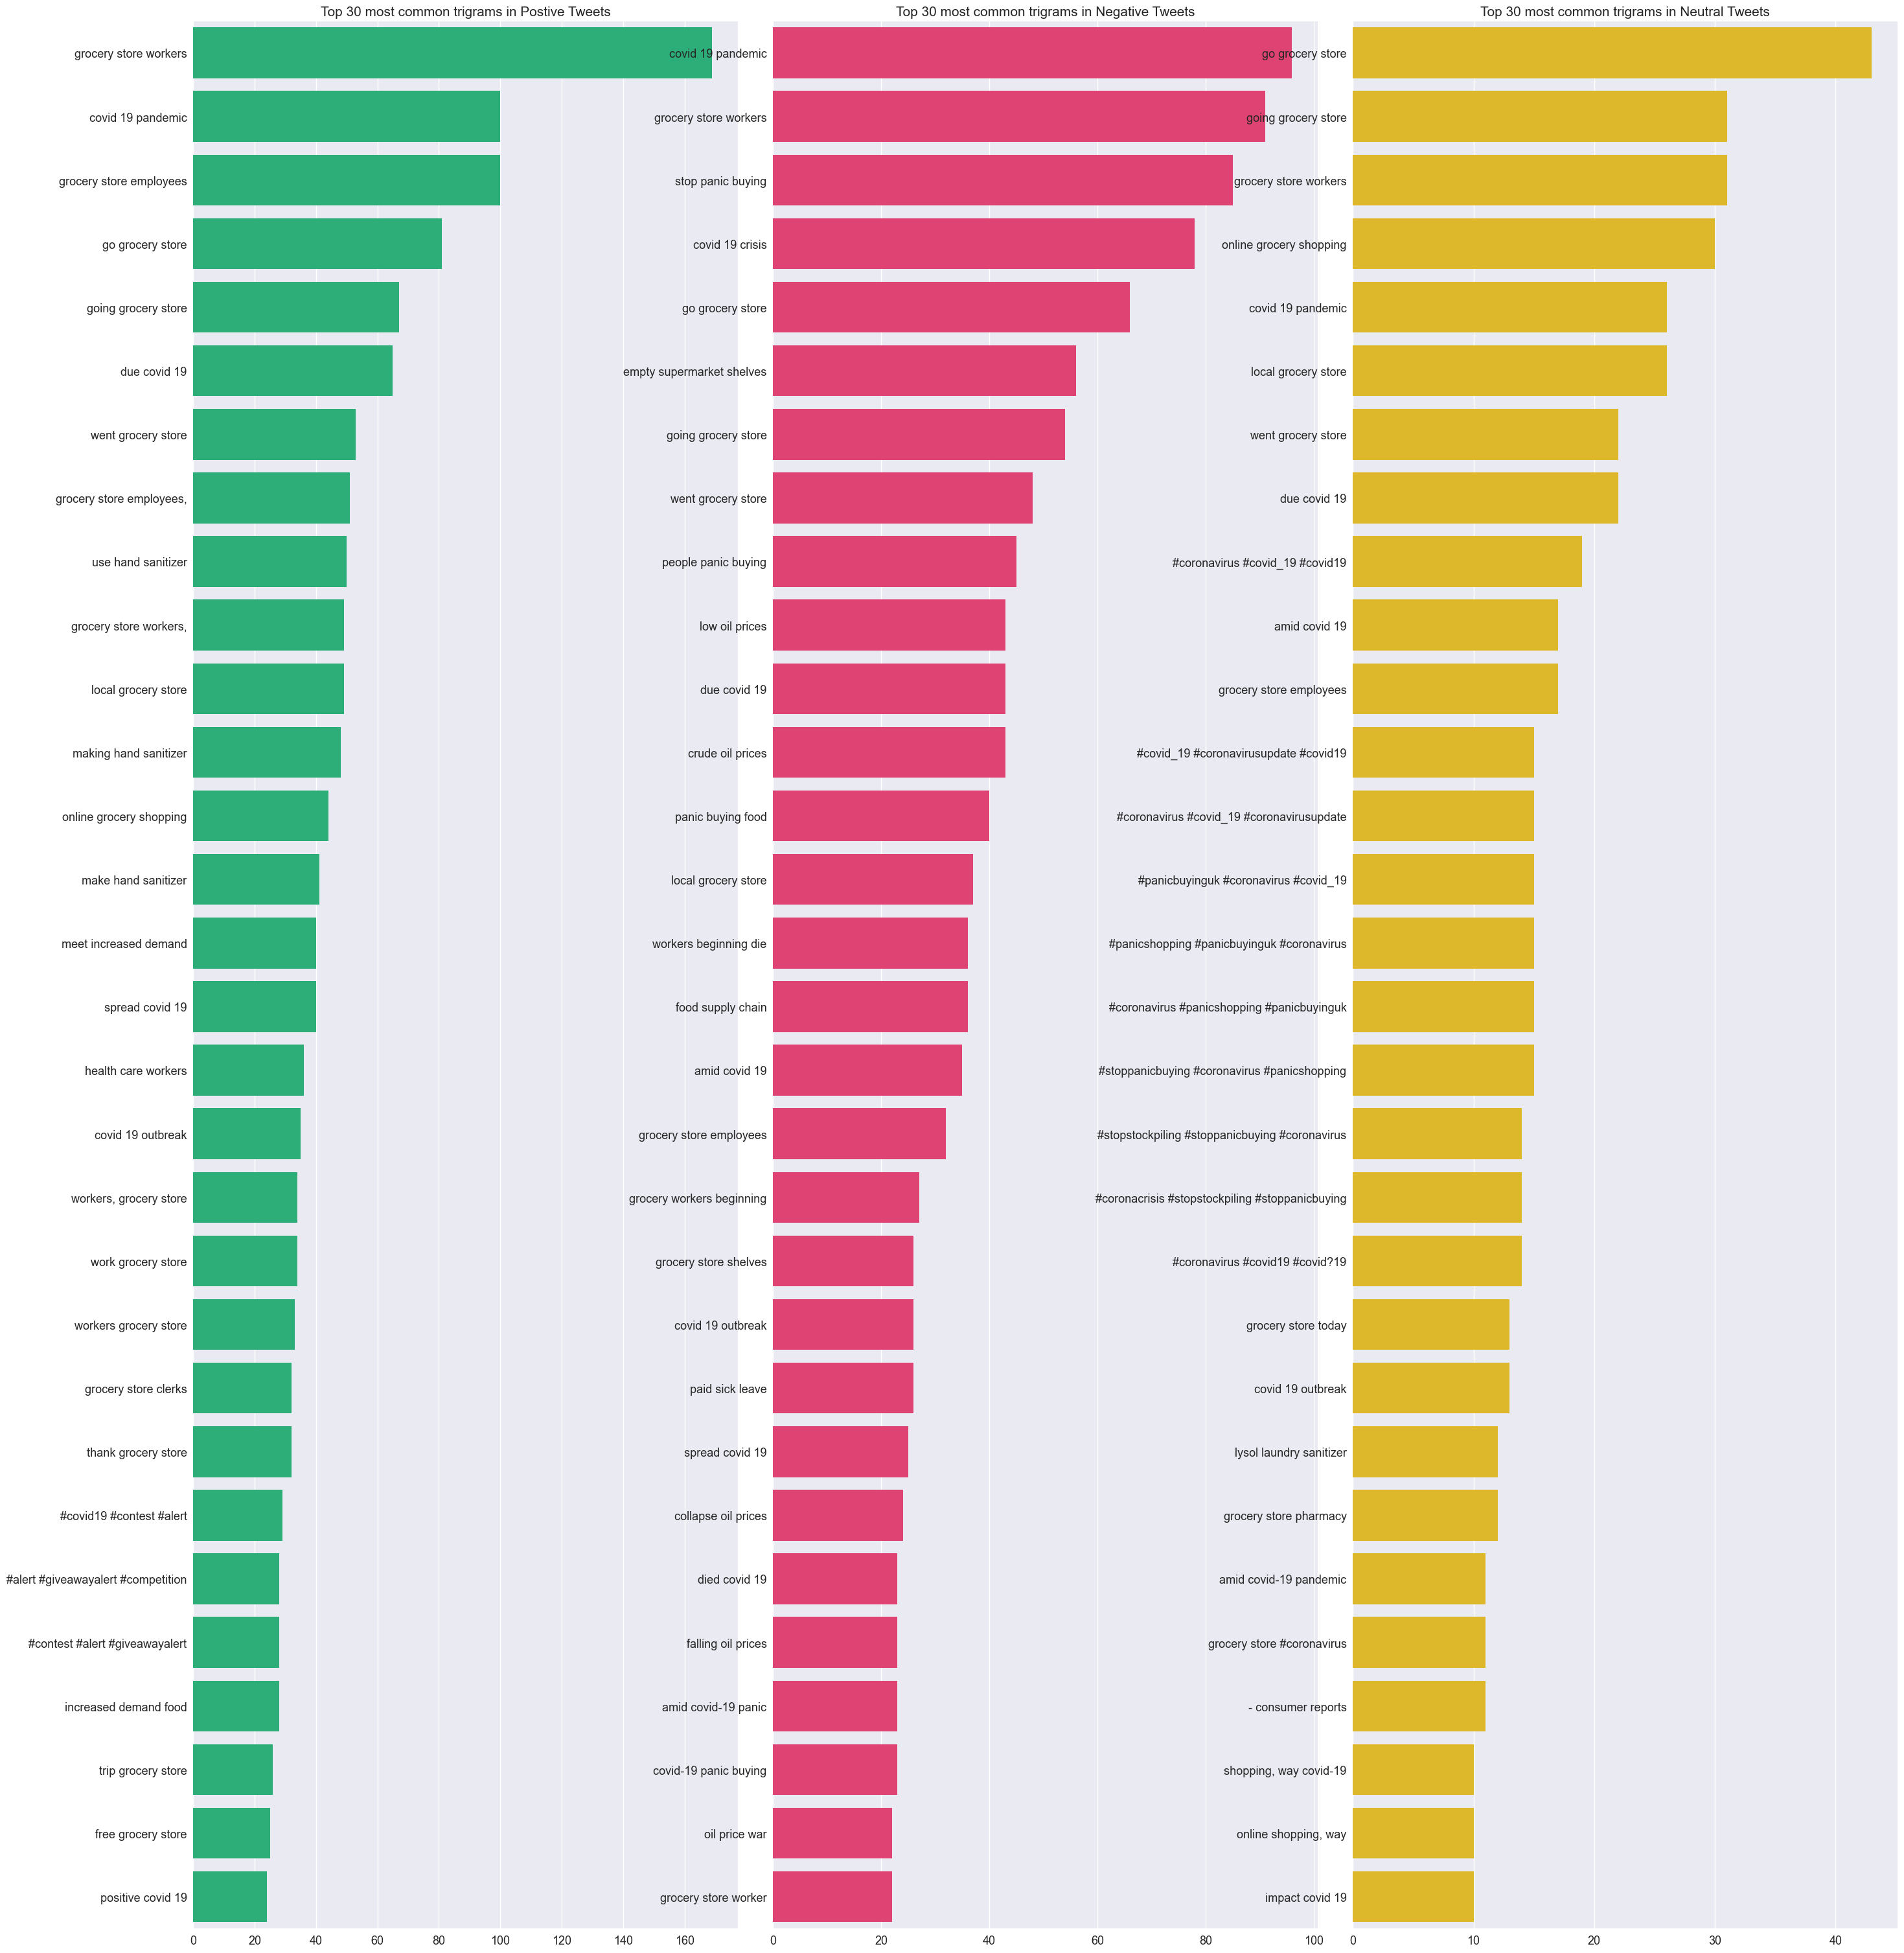

In [43]:
# Trigrams
positive_trigrams = defaultdict(int)
neutral_trigrams = defaultdict(int)
negative_trigrams = defaultdict(int)

for tweet in train[positive]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        positive_trigrams[word] += 1
        
for tweet in train[negative]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        negative_trigrams[word] += 1
        
for tweet in train[neutral]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        neutral_trigrams[word] += 1        
        
df_positive_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
df_negative_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
df_neutral_trigrams = pd.DataFrame(sorted(neutral_trigrams.items(), key=lambda x: x[1])[::-1])


fig, axes = plt.subplots(ncols=3, figsize=(27, 30), dpi=100)
plt.tight_layout()

sns.barplot(y=df_positive_trigrams[0].values[:N], x=df_positive_trigrams[1].values[:N], ax=axes[0], color='#17C37B')
sns.barplot(y=df_negative_trigrams[0].values[:N], x=df_negative_trigrams[1].values[:N], ax=axes[1], color='#F92969')
sns.barplot(y=df_neutral_trigrams[0].values[:N], x=df_neutral_trigrams[1].values[:N], ax=axes[2], color='#FACA0C')




for i in range(3):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common trigrams in Postive Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Negative Tweets', fontsize=15)
axes[2].set_title(f'Top {N} most common trigrams in Neutral Tweets', fontsize=15)

plt.show()

In [44]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\STARIZ.PK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Here we have read the file named “Corona_NLP_train” in CSV(comma-separated value) format. And have checked for the top 5 values in the dataset using head()

In [45]:
data = pd.read_csv("Corona_NLP_train.csv",encoding='latin1')
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [46]:
df = pd.DataFrame(data)
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Further, I have performed some data visualizations using matplotlib and seaborn libraries which are really the best visualization libraries in Python. I have plotted only one graph, you can plot more graphs to see how your data is!

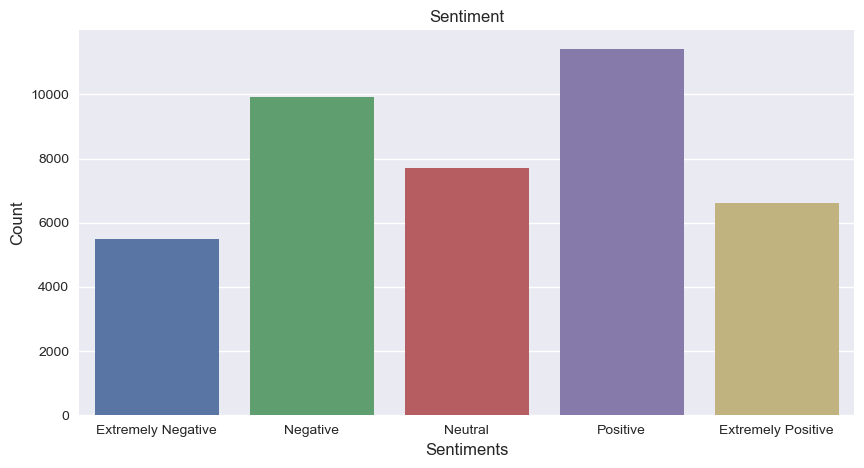

In [47]:
plt.figure(figsize=(10,5))
sns.countplot(x='Sentiment', data=df, order=['Extremely Negative', 'Negative', 'Neutral', 'Positive', 'Extremely Positive'])
plt.title("Sentiment")
plt.ylabel("Count", fontsize = 12)
plt.xlabel("Sentiments",fontsize = 12)
plt.show()

In this step, we are able to see how the summary of our data like No. of columns with their data types.

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Here we will perform a regular expression function to remove any symbols and special characters, etc to get pure data.

In [49]:
reg = re.compile("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z t])|(w+://S+)")
tweet = []
for i in df["OriginalTweet"]:
    tweet.append(reg.sub(" ", i))
df = pd.concat([df, pd.DataFrame(tweet, columns=["CleanedTweet"])], axis=1, sort=False)

Now we can see cleaned data obtained from the above code.

In [50]:
df.head(10)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanedTweet
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,Gahan https t co iFz9FAn2Pa and https ...
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,advice Talk to your neighbours family to excha...
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,Coronavirus Australia Woolworths to give elde...
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,My food stock is not the only one which is emp...
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,Me ready to go at supermarket during the ou...
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive,As news of the region s first confirmed COVID...
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive,Cashier at grocery store was sharing his insig...
7,3806,48758,Austria,16-03-2020,Was at the supermarket today. Didn't buy toile...,Neutral,Was at the supermarket today Didn t buy toile...
8,3807,48759,"Atlanta, GA USA",16-03-2020,Due to COVID-19 our retail store and classroom...,Positive,Due to COVID 19 our retail store and classroom...
9,3808,48760,"BHAVNAGAR,GUJRAT",16-03-2020,"For corona prevention,we should stop to buy th...",Negative,For corona prevention we should stop to buy th...


now convert text into the matrix of tokens, we have to import the following library and perform code.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
stop_words = set(stopwords.words('english'))     # make a set of stopwords
vectoriser = TfidfVectorizer(stop_words=None)

LabelEncoder is used here for transforming categorical values into numerical values.

#  Modeling

In [52]:
X_train = vectoriser.fit_transform(df["CleanedTweet"])
# Encoding the classes in numerical values
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train = encoder.fit_transform(df['Sentiment'])
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

Let’s do all operations for test data also.

In [53]:
# importing the Test dataset for prediction and testing purposes
test_data = pd.read_csv("Corona_NLP_test.csv",encoding='latin1')
test_df = pd.DataFrame(test_data)
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


Here we will perform a regular expression function to remove any symbols and special character, etc to get pure test data.

In [54]:
reg1 = re.compile("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|([^0-9A-Za-z t])|(w+://S+)")
tweet = []
for i in test_df["OriginalTweet"]:
    tweet.append(reg1.sub(" ", i))
test_df = pd.concat([test_df, pd.DataFrame(tweet, columns=["CleanedTweet"])], axis=1, sort=False)
test_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanedTweet
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING New Yorkers encounter empty supermar...
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When I couldn t find hand sanitizer at Fred Me...
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative,buying hits City as anxious shoppers stock...
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,19 One week everyone...


By using vectorization, we have performed normalization of test data and stored it into x_test & y_test. We have also predicted actual and predicted values.

In [55]:
X_test = vectoriser.transform(test_df["CleanedTweet"])
y_test = encoder.transform(test_df["Sentiment"])
# Prediction
y_pred = classifier.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
pred_df.head()

,Actual,Predicted
0,0,4
1,4,4
2,1,4
3,2,2
4,3,2


So, at last, we have performed the accuracy of our model in the form of an AUC curve plotted using the matplotlib library.

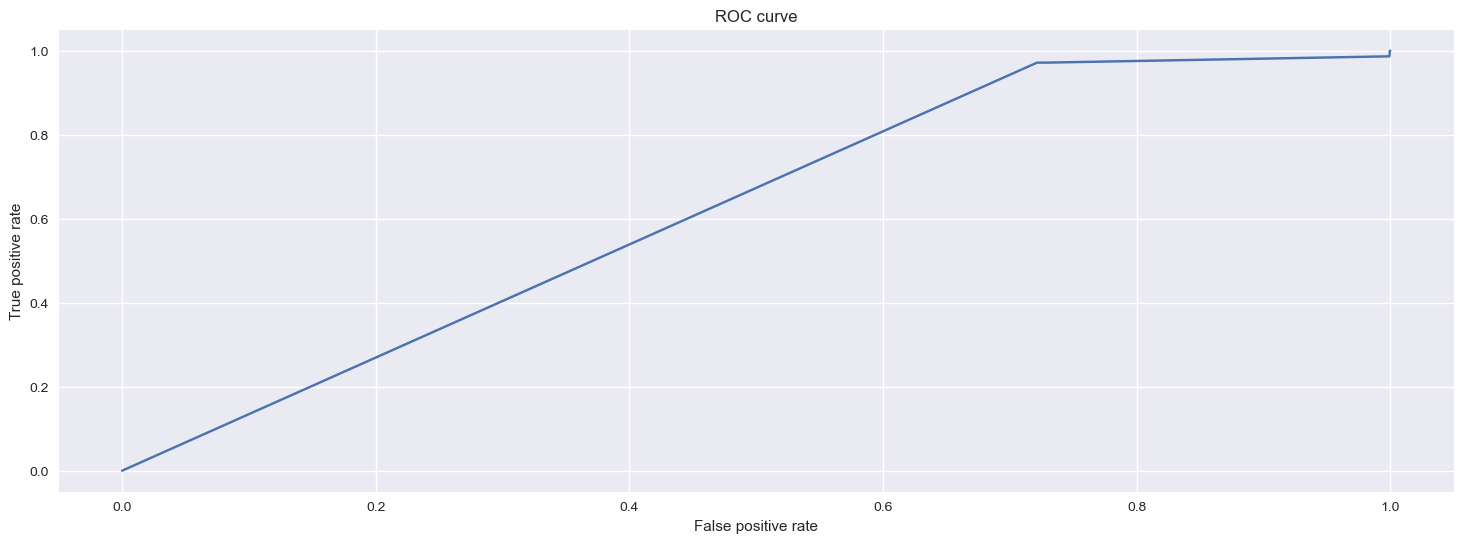

AUC of the predictions: 0.6231713165790018


In [56]:
from sklearn import metrics
# Generate the roc curve using scikit-learn.
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
# Measure the area under the curve. The closer to 1, the "better" the predictions.
print("AUC of the predictions: {0}".format(metrics.auc(fpr, tpr)))

Here we got a score of `AUC – 0.64` for the classifier (Naive Byes), we can say that the classifier (Naive Bayes) is not that so good but can acceptable. Since the more nearer to 1 AUC score, the classifier will be better.

In the same way, we can perform any sentimental analysis of “tweets”.